In [1]:
import pandas as pd
# Load the newly uploaded dataset to inspect and prepare for model building
df_new = pd.read_csv('AirQualityIBEROCDMX.csv')

# Display the first few rows to understand its structure
df_new.head()


,Timestamp,PM2.5 [ug/m3],PM10[ug/m3],Ozone [ppb],Carbon_Monoxide [ppb],Temperature [°C],Relative_Humidity [%]
0,31/01/2022 12:00:00,13.181818,14.181818,456.090909,371.909091,20.413636,28.798182
1,31/01/2022 13:00:00,16.333333,17.333333,78.833333,405.750000,22.851667,22.753333
2,31/01/2022 14:00:00,25.480000,26.893333,44.280000,407.946667,24.910667,19.626133
3,31/01/2022 15:00:00,26.701058,28.343915,39.462963,405.023810,25.443915,19.002831
4,31/01/2022 16:00:00,32.166667,34.166667,33.916667,399.416667,23.152500,22.096667


In [2]:
# Convert the 'Timestamp' to datetime format and create time-based features
df_new['Timestamp'] = pd.to_datetime(df_new['Timestamp'], format='%d/%m/%Y %H:%M:%S')
df_new['Hour'] = df_new['Timestamp'].dt.hour
df_new['Day'] = df_new['Timestamp'].dt.day
df_new['Month'] = df_new['Timestamp'].dt.month
df_new['Day_of_Week'] = df_new['Timestamp'].dt.dayofweek

# Create rolling averages for pollutants (7-hour window)
df_new['PM2.5_Rolling'] = df_new['PM2.5 [ug/m3]'].rolling(window=7).mean()
df_new['PM10_Rolling'] = df_new['PM10[ug/m3]'].rolling(window=7).mean()
df_new['Ozone_Rolling'] = df_new['Ozone [ppb]'].rolling(window=7).mean()
df_new['CO_Rolling'] = df_new['Carbon_Monoxide [ppb]'].rolling(window=7).mean()

In [3]:
df_new = df_new.dropna()

# Define the features and targets
features = ['PM2.5 [ug/m3]', 'PM10[ug/m3]', 'Ozone [ppb]', 'Carbon_Monoxide [ppb]', 
            'Hour', 'Day', 'Month', 'Day_of_Week', 
            'PM2.5_Rolling', 'PM10_Rolling', 'Ozone_Rolling', 'CO_Rolling']
targets = ['Temperature [°C]', 'Relative_Humidity [%]']

In [4]:
# Split the data into features (X) and targets (y)
X = df_new[features]
y = df_new[targets]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
# Now let's move on to building the deep learning model using TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build the deep learning model
model = Sequential()

# Input layer
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))

# Hidden layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# 2 Output layers\Neurons for Temperature and Humidity 
model.add(Dense(2))  

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluating the model
y_pred = model.predict(X_test_scaled)



Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - loss: 834.1548 - val_loss: 194.7821
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 156.9133 - val_loss: 142.9143
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 125.1553 - val_loss: 128.2898
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 115.2565 - val_loss: 122.2091
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 111.9960 - val_loss: 112.1020
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 103.7992 - val_loss: 107.9014
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 97.4240 - val_loss: 100.5426
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 94.5214 - val_loss: 95.1838
Epoch 9/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 91.6961 - val_loss: 94.6649
Epoch 10/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 90.9142 - val_loss: 90.4261
Epoch 11/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 88.8608 - val_loss: 88.3905
Epoch 

In [6]:
#Calculating the accuracy of the model
from sklearn.metrics import mean_squared_error, r2_score

# For Temperature
temp_mse = mean_squared_error(y_test['Temperature [°C]'], y_pred[:, 0])
temp_r2 = r2_score(y_test['Temperature [°C]'], y_pred[:, 0])

# For Humidity
humidity_mse = mean_squared_error(y_test['Relative_Humidity [%]'], y_pred[:, 1])
humidity_r2 = r2_score(y_test['Relative_Humidity [%]'], y_pred[:, 1])

temp_mse, temp_r2, humidity_mse, humidity_r2

print(f"The MSE for the temperature is: {temp_mse}")
print(f"The R2 Score for the Temperature is: {temp_r2}")
print("\n")
print(f"The MSE for Humidity is: {humidity_mse}")
print(f"The R2 score for the Humidity is: {humidity_r2}")

The MSE for the temperature is: 4.132045752236154
The R2 Score for the Temperature is: 0.8224906373094014


The MSE for Humidity is: 125.23788713042318
The R2 score for the Humidity is: 0.7400692868544625


### Model Tuning:

In [9]:
# Build the tuned deep learning model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

# new model with more layers, neurons
model_tuned = Sequential()

# Input layer
model_tuned.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))

# Building the hidden layers with more layers and neurons
model_tuned.add(Dense(256, activation='relu'))
model_tuned.add(Dropout(0.3))  # Dropout layer to prevent overfitting
model_tuned.add(Dense(128, activation='relu'))
model_tuned.add(Dropout(0.3))
model_tuned.add(Dense(64, activation='relu'))

# 2 output layers
model_tuned.add(Dense(2))

# Compile the model with a lower learning rate for lesser mistakes
optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate
model_tuned.compile(optimizer=optimizer, loss='mean_squared_error')




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
#train the model for more epochs
history_tuned = model_tuned.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluate the model
y_pred_tuned = model_tuned.predict(X_test_scaled)


Epoch 1/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - loss: 1462.1365 - val_loss: 2689.6348
Epoch 2/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 388.9806 - val_loss: 1808.5364
Epoch 3/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 278.0540 - val_loss: 1329.3234
Epoch 4/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 237.1684 - val_loss: 1039.2853
Epoch 5/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 284.9871 - val_loss: 806.0002
Epoch 6/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 187.1047 - val_loss: 663.5673
Epoch 7/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 180.8427 - val_loss: 546.1167
Epoch 8/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 165.4156 - val_loss: 453.5749
Epoch 9/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 155.6380 - val_loss: 379.1359
Epoch 10/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 158.1568 - val_loss: 311.9195
Epoch 11/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 

In [15]:
#checking out the accuracy: 
from sklearn.metrics import mean_squared_error, r2_score

# For Temperature
temp_mse_tuned = mean_squared_error(y_test['Temperature [°C]'], y_pred_tuned[:, 0])
temp_r2_tuned = r2_score(y_test['Temperature [°C]'], y_pred_tuned[:, 0])

# For Humidity
humidity_mse_tuned = mean_squared_error(y_test['Relative_Humidity [%]'], y_pred_tuned[:, 1])
humidity_r2_tuned = r2_score(y_test['Relative_Humidity [%]'], y_pred_tuned[:, 1])

# Output the new metrics
temp_mse_tuned, temp_r2_tuned, humidity_mse_tuned, humidity_r2_tuned

print(f"MSE for Temperaure(Tuned): {temp_mse_tuned}")
print(f"R2 Score for Temperature (tuned): {temp_r2_tuned}")
print("\n")
print(f"MSE for Humidity(Tuned): {humidity_mse_tuned}")
print(f"R2 Score for Humidity(Tuned): {humidity_r2_tuned}")

MSE for Temperaure(Tuned): 5.479051769744046
R2 Score for Temperature (tuned): 0.7646243420054761


MSE for Humidity(Tuned): 144.82628476555064
R2 Score for Humidity(Tuned): 0.699413649144968


In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Simplify the model to reduce overfitting
model_simplified = Sequential()

# Mounting the input layer
model_simplified.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))

# Hidden layers with lesser neurons and layers
model_simplified.add(Dense(64, activation='relu'))
model_simplified.add(Dense(32, activation='relu'))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model_simplified.add(Dense(2))

# Compiling the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)  
model_simplified.compile(optimizer=optimizer, loss='mean_squared_error')

# reducing learning rate
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

history_simplified = model_simplified.fit(X_train_scaled, y_train, epochs=100, batch_size=32,
                                          validation_data=(X_test_scaled, y_test), callbacks=[lr_scheduler])

Epoch 1/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 931.9272 - val_loss: 221.5068 - learning_rate: 0.0010
Epoch 2/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 166.7240 - val_loss: 151.0758 - learning_rate: 0.0010
Epoch 3/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 127.4995 - val_loss: 134.7524 - learning_rate: 0.0010
Epoch 4/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 119.0239 - val_loss: 120.8153 - learning_rate: 0.0010
Epoch 5/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 114.1367 - val_loss: 115.0681 - learning_rate: 0.0010
Epoch 6/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 106.1866 - val_loss: 107.8752 - learning_rate: 0.0010
Epoch 7/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 102.0277 - val_loss: 107.4581 - learning_rate: 0.0010
Epoch 8/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 96.1665 - val_loss: 99.1524 - learning_rate: 0.0010
Epoch 9/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 93.

In [18]:
# Evaluating the model
y_pred_simplified = model_simplified.predict(X_test_scaled)


temp_mse_simplified = mean_squared_error(y_test['Temperature [°C]'], y_pred_simplified[:, 0])
temp_r2_simplified = r2_score(y_test['Temperature [°C]'], y_pred_simplified[:, 0])


humidity_mse_simplified = mean_squared_error(y_test['Relative_Humidity [%]'], y_pred_simplified[:, 1])
humidity_r2_simplified = r2_score(y_test['Relative_Humidity [%]'], y_pred_simplified[:, 1])


temp_mse_simplified, temp_r2_simplified, humidity_mse_simplified, humidity_r2_simplified

print(f"MSE for Temperature(Simplified): {temp_mse_simplified}")
print(f"R2 Score for Temperature(Simplified): {temp_r2_simplified}")
print("\n")
print(f"MSE for Humidity(Simplified): {humidity_mse_tuned}")
print(f"R2 Score for Humidity(Simplified): {humidity_r2_simplified}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step
MSE for Temperature(Simplified): 4.206277073182731
R2 Score for Temperature(Simplified): 0.8193017194553875


MSE for Humidity(Simplified): 144.82628476555064
R2 Score for Humidity(Simplified): 0.7179407101270179


### Using XGBoost:

In [34]:
# Step 1: Rename columns to remove special characters
df_new.columns = df_new.columns.str.replace(r'[^\w\s]', '', regex=True)

# Step 2: Define features and targets after cleaning column names
features = [
    'PM25 ugm3', 'PM10ugm3',
    'Hour', 'Day', 'Month', 'Day_of_Week',
    'PM25_Rolling', 'PM10_Rolling', 'Ozone_Rolling', 'CO_Rolling'
]
targets = ['Temperature', 'Humidity']

# Step 3: Split the data into features (X) and targets (y)
X = df_new[features]
y = df_new[targets]

# Step 4: Align features and targets (ensure they have the same index)
X, y = X.align(y, join='inner')

In [35]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
# split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build models for temp and humidity
model_temp = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)
model_humidity = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)


In [44]:
#Training, Evaluating and Calculating

# ran into an error and we need to ensure the correct column names are used for targets
features = [
    'PM25 ugm3', 'PM10ugm3',
    'Hour', 'Day', 'Month', 'Day_of_Week',
    'PM25_Rolling', 'PM10_Rolling', 'Ozone_Rolling', 'CO_Rolling'
]

targets = ['Temperature', 'Humidity']


X = df_new[features]
y = df_new[targets]

# splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mount XGBoost models for Temperature and Humidity
model_temp = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100, learning_rate=0.1, max_depth=6)
model_humidity = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100, learning_rate=0.1, max_depth=6)

# Train the models with the correct column names
model_temp.fit(X_train, y_train['Temperature'])   # Use the correct target column name here
model_humidity.fit(X_train, y_train['Humidity'])

y_pred_temp = model_temp.predict(X_test)
y_pred_humidity = model_humidity.predict(X_test)



In [45]:
#Calculating the scores 
# For Temperature
temp_mse = mean_squared_error(y_test['Temperature'], y_pred_temp)
temp_r2 = r2_score(y_test['Temperature'], y_pred_temp)

# For Humidity
humidity_mse = mean_squared_error(y_test['Humidity'], y_pred_humidity)
humidity_r2 = r2_score(y_test['Humidity'], y_pred_humidity)

print(f"Temperature MSE: {temp_mse:.2f}, R²: {temp_r2:.4f}")
print(f"Humidity MSE: {humidity_mse:.2f}, R²: {humidity_r2:.4f}")

Temperature MSE: 2.26, R²: 0.9027
Humidity MSE: 81.80, R²: 0.8302


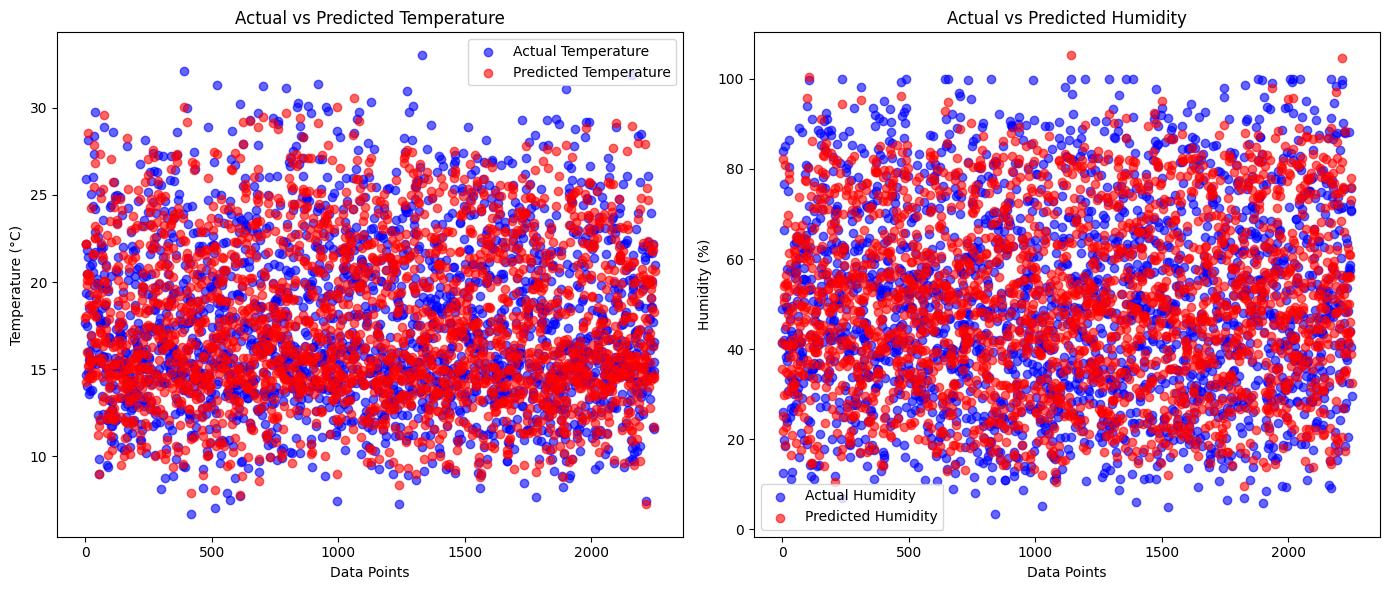

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the test set
y_pred_temp = model_temp.predict(X_test)
y_pred_humidity = model_humidity.predict(X_test)

# Create a figure and axis for Temperature
plt.figure(figsize=(14, 6))

# Temperature: Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(np.arange(len(y_test)), y_test['Temperature'], color='blue', label='Actual Temperature', alpha=0.6)
plt.scatter(np.arange(len(y_test)), y_pred_temp, color='red', label='Predicted Temperature', alpha=0.6)
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Data Points')
plt.ylabel('Temperature (°C)')
plt.legend()

# Humidity: Actual vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(np.arange(len(y_test)), y_test['Humidity'], color='blue', label='Actual Humidity', alpha=0.6)
plt.scatter(np.arange(len(y_test)), y_pred_humidity, color='red', label='Predicted Humidity', alpha=0.6)
plt.title('Actual vs Predicted Humidity')
plt.xlabel('Data Points')
plt.ylabel('Humidity (%)')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


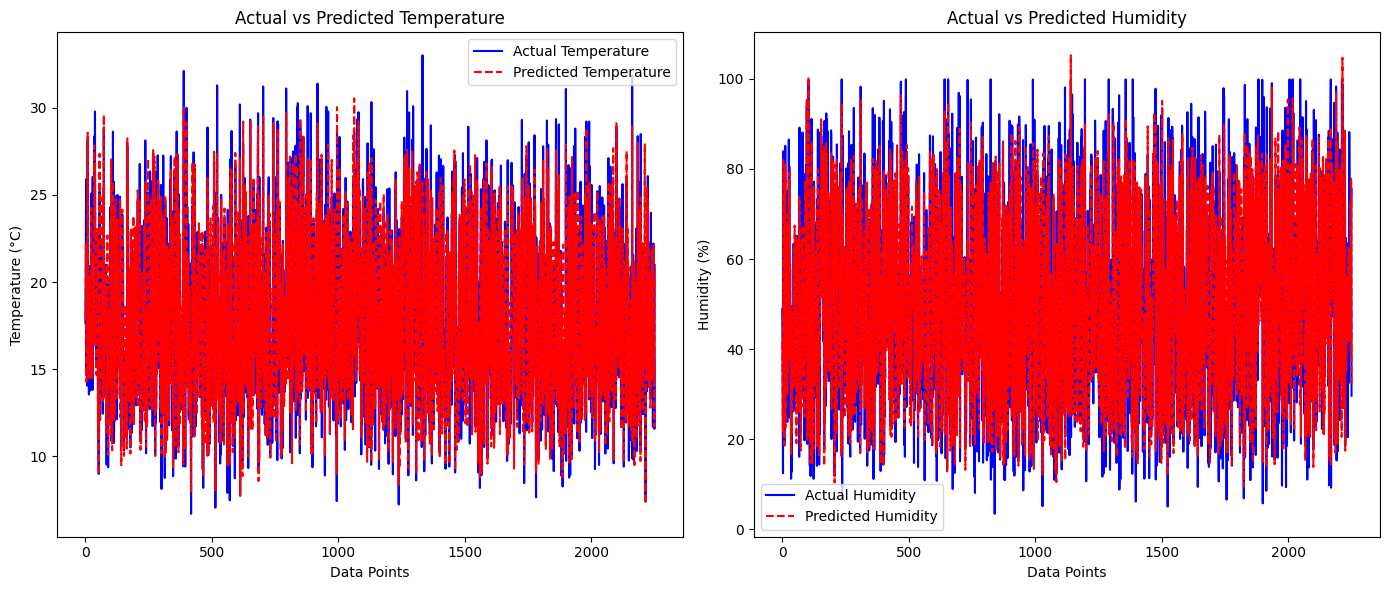

In [52]:
#Line Graph

import matplotlib.pyplot as plt
import numpy as np

# # Make predictions on the test set
# y_pred_temp = model_temp.predict(X_test)
# y_pred_humidity = model_humidity.predict(X_test)

# Create a figure for Temperature and Humidity line graphs
plt.figure(figsize=(14, 6))

# Temperature: Actual vs Predicted
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(y_test)), y_test['Temperature'], color='blue', label='Actual Temperature')
plt.plot(np.arange(len(y_test)), y_pred_temp, color='red', label='Predicted Temperature', linestyle='--')
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Data Points')
plt.ylabel('Temperature (°C)')
plt.legend()

# Humidity: Actual vs Predicted
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(y_test)), y_test['Humidity'], color='blue', label='Actual Humidity')
plt.plot(np.arange(len(y_test)), y_pred_humidity, color='red', label='Predicted Humidity', linestyle='--')
plt.title('Actual vs Predicted Humidity')
plt.xlabel('Data Points')
plt.ylabel('Humidity (%)')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


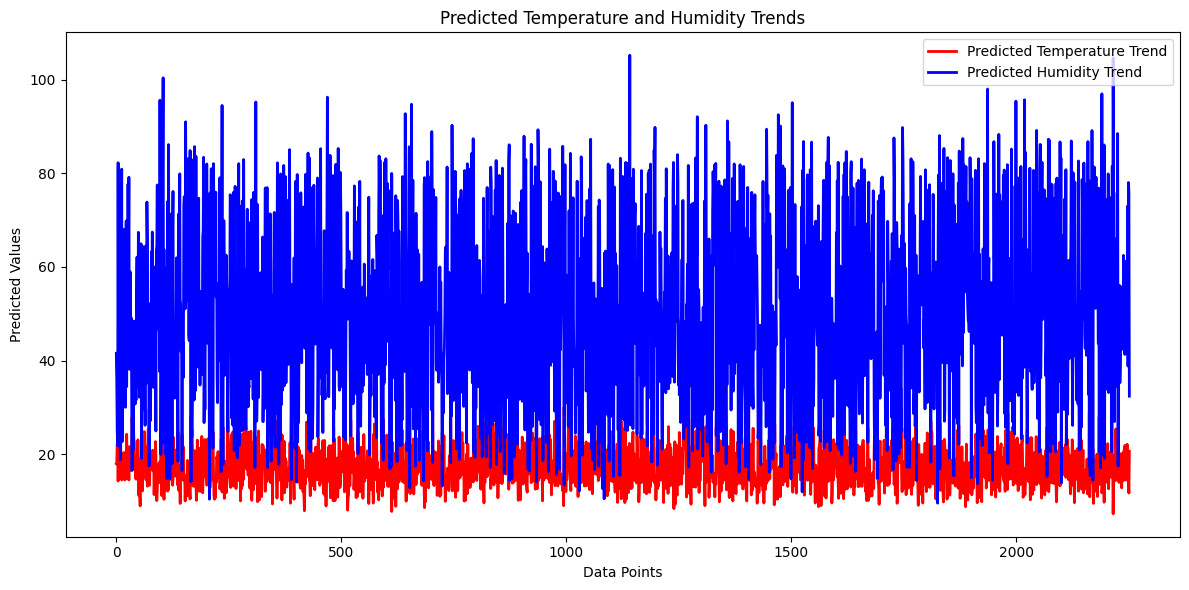

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `y_pred_temp` contains predicted Temperature values and `y_pred_humidity` contains predicted Humidity values

# Create a figure for plotting the trends of predicted values
plt.figure(figsize=(12, 6))

# Temperature: Predicted Trend
plt.plot(np.arange(len(y_pred_temp)), y_pred_temp, color='red', label='Predicted Temperature Trend', linewidth=2)
plt.plot(np.arange(len(y_pred_humidity)), y_pred_humidity, color='blue', label='Predicted Humidity Trend', linewidth=2)
plt.title('Predicted Temperature and Humidity Trends')
plt.xlabel('Data Points')
plt.ylabel('Predicted Values')
plt.legend()

# Show the graph
plt.tight_layout()
plt.show()


/var/folders/wv/lgt7rwvx5dn_v1y74zftwswh0000gn/T/ipykernel_35894/3178494782.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start="2024-07-30", periods=len(y_pred_temp), freq='H')  # Adjust frequency as needed


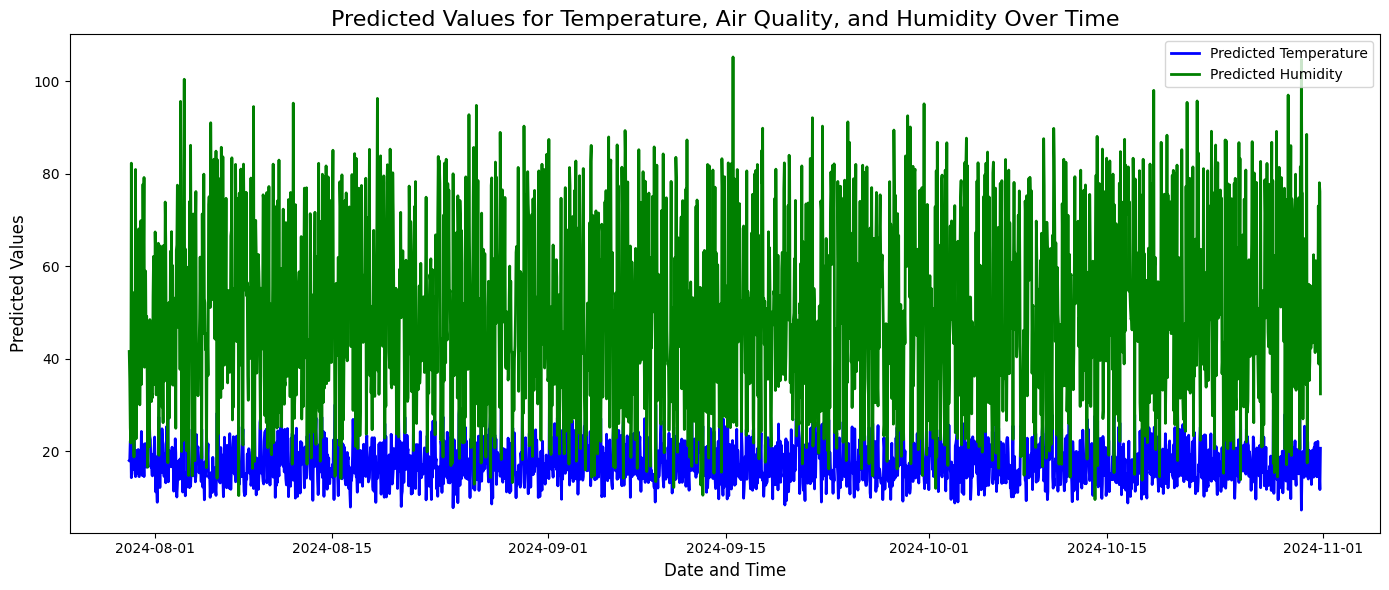

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Let's assume we have predictions for temperature, air quality, and humidity
# Replace the variables below with the actual predictions
# For example, replace `y_pred_temp` with the actual predicted temperature values

# Simulated data (replace with your actual predictions)
dates = pd.date_range(start="2024-07-30", periods=len(y_pred_temp), freq='H')  # Adjust frequency as needed

# Create a figure
plt.figure(figsize=(14, 6))

# Plot the predicted temperature trend
plt.plot(dates, y_pred_temp, label='Predicted Temperature', color='blue', linewidth=2)

# Plot the predicted air quality trend (replace y_pred_air_quality with actual predictions)
# If you don't have air quality predictions, you can exclude this line
# plt.plot(dates, y_pred_air_quality, label='Predicted Air Quality', color='red', linewidth=2)

# Plot the predicted humidity trend
plt.plot(dates, y_pred_humidity, label='Predicted Humidity', color='green', linewidth=2)

# Add title and labels
plt.title('Predicted Values for Temperature, Air Quality, and Humidity Over Time', fontsize=16)
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)

# Show the legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


1. The blue line represents the predicted temperature values. These appear relatively steady over time, fluctuating within a narrow range (likely between 15°C and 30°C). This steady behavior suggests that the model predicts small variations in temperature over time.

Compared to humidity, temperature appears to have lower variability in this forecast.

2. The green line represents the predicted humidity values. Humidity values are more volatile than temperature, with large fluctuations throughout the entire time period, ranging from 20% to over 100%.

High variability in the humidity line suggests the model predicts sharp changes in humidity levels. This could either reflect real-world volatility or the model struggling to capture stable trends.

